Compare the change in extreme precipitation between the LWoff and +4K experiments.... is there correspondence? 

In [1]:
from collections import namedtuple
import xarray as xr
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pathlib import Path

# from sklearn.neighbors import KernelDensity
import colorcet as cc

from pathlib import Path
import esmlab
import scipy.stats as stats

In [2]:
model_colors = {}
for i, m in [(0, "cesm"), (1, "cnrm"), (2, "ipsl"), (3, "mri"), (6, "hadgem")]:
    model_colors[m] = cc.cm.glasbey_hv(i) 


# hard code locking to other blues, assumes CESM is first in list.
model_colors['f-lock'] = cc.cm.glasbey_hv(5)
model_colors['f-cntl'] = model_colors['f-lock']
model_colors['c-lock'] = cc.cm.glasbey_hv(8)
model_colors['c-cntl'] = model_colors['c-lock']

In [3]:
def quick_load_var(loc, var, table, model, experiment, member):
    fils = sorted(
        list(Path(loc).glob("_".join([var, table, model, experiment, member, "*.nc"])))
    )
    if len(fils) == 0:
        raise IOError("Can not find the files.")
    elif len(fils) == 1:
        ds = xr.open_dataset(fils[0])
    else:
        ds = xr.open_mfdataset(fils, combine="by_coords")
    return ds[var].compute()

In [4]:
DRIVE = Path("/Volumes/Jedha")
data_loc = DRIVE / "CMIP6"

In [5]:
## do these:

exp0 = "amip"
exp1 = "amip-lwoff"
exp2 = "amip-p4K"
exp2a = "amip-p4K-lwoff"
exp3 = "aqua-control"
exp4 = "aqua-control-lwoff"
exp5 = "aqua-p4K"
exp5a = "aqua-p4K-lwoff"
exp6 = "amip-4xCO2"
exp7 = "aqua-4xCO2"

sims = {"cesm-amip": ("CESM2", exp0, "r1i1p1f1"),
        "cesm-amip-off": ("CESM2", exp1, "r1i1p1f1"),
        "cesm-amip-4k": ("CESM2", exp2, "r1i1p1f1"),
        "cesm-amip-4k-off": ("CESM2", exp2a, "r1i1p1f1"),
        "cesm-aqua": ("CESM2", exp3, "r1i1p1f1"),
        "cesm-aqua-off": ("CESM2", exp4, "r1i1p1f1"),
        "cesm-aqua-4k": ("CESM2", exp5, "r1i1p1f1"), 
        "cesm-aqua-4k-off": ("CESM2", exp5a, "r1i1p1f1"),
        "cesm-aqua-4xCO2" : ("CESM2", exp7, "r1i1p1f1"),
        "cesm-amip-4xCO2" : ("CESM2", exp6, "r1i1p1f1"),
        "ipsl-amip": ("IPSL-CM6A-LR", exp0, "r1i1p1f1"),
        "ipsl-amip-off": ("IPSL-CM6A-LR", exp1, "r1i1p1f1"),
        "ipsl-amip-4k": ("IPSL-CM6A-LR", exp2, "r1i1p1f1"),
        "ipsl-amip-4k-off": ("IPSL-CM6A-LR", exp2a, "r1i1p1f1"),
        "ipsl-aqua": ("IPSL-CM6A-LR", exp3, "r1i1p1f1"),
        "ipsl-aqua-off": ("IPSL-CM6A-LR", exp4, "r1i1p1f1"),
        "ipsl-aqua-4k": ("IPSL-CM6A-LR", exp5, "r1i1p1f1"),
        "ipsl-aqua-4k-off": ("IPSL-CM6A-LR", exp5a, "r1i1p1f1"),
        "ipsl-aqua-4xCO2" : ("IPSL-CM6A-LR", exp7, "r1i1p1f1"),
        "ipsl-amip-4xCO2" : ("IPSL-CM6A-LR", exp6, "r1i1p1f1"),
        "cnrm-amip": ("CNRM-CM6-1", exp0, "r1i1p1f2"),
        "cnrm-amip-off": ("CNRM-CM6-1", exp1, "r1i1p1f2"),
        "cnrm-amip-4k": ("CNRM-CM6-1", exp2, "r1i1p1f2"),
        "cnrm-amip-4k-off": ("CNRM-CM6-1", exp2a, "r1i1p1f2"),
        "cnrm-aqua": ("CNRM-CM6-1", exp3, "r1i1p1f2"),
        "cnrm-aqua-off": ("CNRM-CM6-1", exp4, "r1i1p1f2"),
        "cnrm-aqua-4k": ("CNRM-CM6-1", exp5, "r1i1p1f2"),
        "cnrm-aqua-4k-off": ("CNRM-CM6-1", exp5a, "r1i1p1f2"),
        "cnrm-aqua-4xCO2" : ("CNRM-CM6-1", exp7, "r1i1p1f2"),
        "cnrm-amip-4xCO2" : ("CNRM-CM6-1", exp6, "r1i1p1f2"),
        "mri-amip" : ("MRI-ESM2-0", exp0, "r1i1p1f1"),
        "mri-amip-off" : ("MRI-ESM2-0", exp1, "r1i1p1f1"),
        "mri-amip-4k" : ("MRI-ESM2-0", exp2, "r1i1p1f1"),
        "mri-amip-4k-off" : ("MRI-ESM2-0", exp2a, "r1i1p1f1"),
        "mri-amip-4xCO2" : ("MRI-ESM2-0", exp6, "r1i1p1f1"),
        "hadgem-amip" :("HadGEM3-GC31-LL", exp0, "r1i1p1f3"),
        "hadgem-amip-off": ("HadGEM3-GC31-LL", exp1, "r5i1p1f2"),
        "hadgem-amip-4k":("HadGEM3-GC31-LL", exp2, "r5i1p1f3"),
        "hadgem-amip-4xCO2": ("HadGEM3-GC31-LL", exp6, "r5i1p1f3"),
        "hadgem-aqua" :("HadGEM3-GC31-LL", exp3, "r1i1p1f3"),
        "hadgem-aqua-off": ("HadGEM3-GC31-LL", exp4, "r1i1p1f3"),
        "hadgem-aqua-4k":("HadGEM3-GC31-LL", exp5, "r1i1p1f3"),
        "hadgem-aqua-4xCO2": ("HadGEM3-GC31-LL", exp7, "r1i1p1f3")
       }


In [6]:
# for each simulation, I want to get:
# - global mean precip
# - global mean precip, ocean only
# - tropical mean precip
# - tropical mean precip, ocean only
# - tropical UNWEIGHTED mean precip, ocean only
# - 95th percentile of tropical ocean precip
# - sum of tropical ocean precip with p >= p95
# - sum of tropical ocean precip
# Define a namedtuple:
Result = namedtuple('Result', ['case', 'gavg', 'goavg', 'tavg', 'toavg', 'toavg_uw', 'p95', 'tsum', 'xsum'])


def get_pr_info(dloc, model, experiment, member):
    tropics = slice(-30,30)
    pr = quick_load_var(data_loc, "pr", "day", model, experiment, member)
    lat = pr['lat']
    wgt = np.cos(np.radians(lat))
    gavg = esmlab.weighted_mean(pr.mean(dim=('time','lon')), dim=["lat"], weights=wgt).item()
    tavg = esmlab.weighted_mean(pr.sel(lat=tropics).mean(dim=('time','lon')), dim=["lat"], weights=wgt.sel(lat=tropics)).item()
    if 'amip' in c:
        land = quick_load_var(data_loc, "sftlf", "fx", model, experiment, member)
        land_trop = land.sel(lat=tropics)
        msk, _ = xr.broadcast(land, pr)
        pr = pr.where(msk <= 0)
        goavg = esmlab.weighted_mean(pr.mean(dim=('time','lon')), dim=["lat"], weights=wgt).item()
        toavg = esmlab.weighted_mean(pr.sel(lat=tropics).mean(dim=('time','lon')), dim=["lat"], weights=wgt.sel(lat=tropics)).item()
    else:
        goavg = gavg
        toavg = tavg
    ptrop = pr.sel(lat=tropics)
    toavg_uw = ptrop.mean().item()
    p95 = np.nanquantile(ptrop.values.flatten(), 0.95)
    tsum = np.nansum(ptrop.values.flatten())
    xsum = np.nansum(ptrop.where(ptrop>=p95).values.flatten())
    return Result("_".join([model,experiment,member]), gavg, goavg, tavg, toavg, toavg_uw, p95, tsum, xsum)


R = {}
for c in sims:
    print(f"working on {c}")
    R[c] = get_pr_info(data_loc, *sims[c])

working on cesm-amip


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cesm-amip-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cesm-amip-4k


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cesm-amip-4k-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cesm-aqua


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


working on cesm-aqua-off
working on cesm-aqua-4k
working on cesm-aqua-4k-off
working on cesm-aqua-4xCO2
working on cesm-amip-4xCO2


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on ipsl-amip


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on ipsl-amip-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on ipsl-amip-4k


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on ipsl-amip-4k-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on ipsl-aqua
working on ipsl-aqua-off
working on ipsl-aqua-4k
working on ipsl-aqua-4k-off
working on ipsl-aqua-4xCO2
working on ipsl-amip-4xCO2


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cnrm-amip


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cnrm-amip-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cnrm-amip-4k


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cnrm-amip-4k-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cnrm-aqua
working on cnrm-aqua-off
working on cnrm-aqua-4k
working on cnrm-aqua-4k-off
working on cnrm-aqua-4xCO2
working on cnrm-amip-4xCO2


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on mri-amip


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on mri-amip-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on mri-amip-4k


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on mri-amip-4k-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on mri-amip-4xCO2


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on hadgem-amip
working on hadgem-amip-off
working on hadgem-amip-4k
working on hadgem-amip-4xCO2
working on hadgem-aqua
working on hadgem-aqua-off
working on hadgem-aqua-4k
working on hadgem-aqua-4xCO2


In [7]:
def frac_diff(acase, bcase):
    return (bcase - acase)/acase



[('cesm-amip', 'cesm-amip-4k'), ('cesm-aqua', 'cesm-aqua-4k'), ('cnrm-amip', 'cnrm-amip-4k'), ('cnrm-aqua', 'cnrm-aqua-4k'), ('ipsl-amip', 'ipsl-amip-4k'), ('ipsl-aqua', 'ipsl-aqua-4k'), ('mri-amip', 'mri-amip-4k'), ('hadgem-amip', 'hadgem-amip-4k'), ('hadgem-aqua', 'hadgem-aqua-4k')]


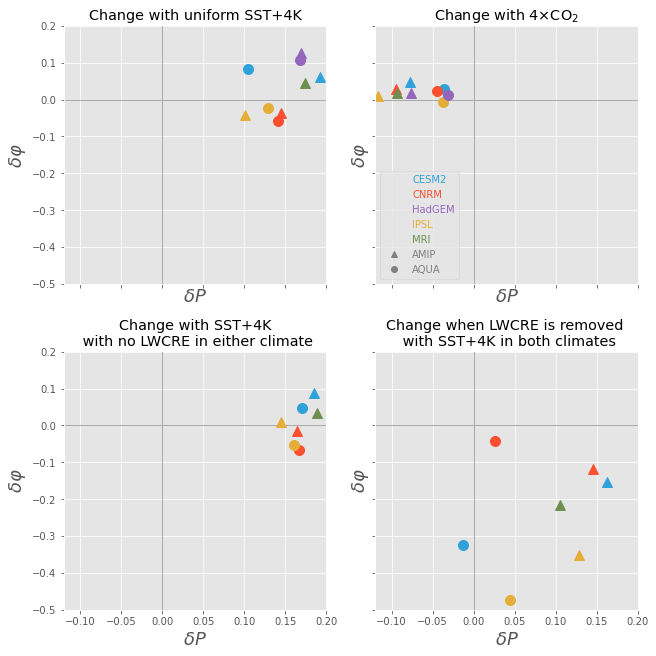

In [8]:
#
# I want to make plot of fractional change in Extreme vs Mean for :
# - warming (base-climate vs p4K)
# - warming w/o LWCRE (lwoff vs p4K-lwoff)
# - CRE in warmer climate (p4K vs p4K-lwoff)

pairs1 = []
pairs2 = []
pairs3 = []
pairs4 = []
for m in ('cesm', 'cnrm', 'ipsl', 'mri', 'hadgem'):
    for a in ('amip', 'aqua'):
        if "-".join([m,a]) in R:
            pairs1.append(("-".join([m,a]), "-".join([m,a,'4k'])))  # base vs p4K
            pairs2.append(("-".join([m,a,'off']), "-".join([m,a,'4k-off'])))  # warming w/o LWCRE
            pairs3.append(("-".join([m,a,'4k']), "-".join([m,a,'4k-off'])))  # CRE in warmer climate
            pairs4.append(("-".join([m,a]), "-".join([m,a,'4xCO2'])))  # base vs 4xCO2

print(pairs1)
with plt.style.context('ggplot'):
    fig, aa = plt.subplots(figsize=(9,9), ncols=2, nrows=2, sharex=True, sharey=True, constrained_layout=True)
    ax = aa.ravel()
    [a.axhline(0.0, linestyle='solid', color='darkgray', linewidth=1) for a in ax]
    [a.axvline(0.0, linestyle='solid', color='darkgray', linewidth=1) for a in ax]
    for i, pairs in enumerate([pairs1, pairs4, pairs2, pairs3]):
        # now get the fractional change in extreme rain
        # for each experiment and keep in a dict:
        # the key should just be the 'experiment' name
        delta_xfrac = {}
        delta_mean = {}
        for c in pairs:
            k = c[1]
            model = k.split('-')[0]
            if (c[0] in R) and (c[1] in R):
                xfrac0 = R[c[0]].xsum/R[c[0]].tsum
                xfrac1 = R[c[1]].xsum/R[c[1]].tsum
                delta_xfrac[k] = frac_diff(xfrac0, xfrac1)
                delta_mean[k] = frac_diff(R[c[0]].toavg, R[c[1]].toavg)
                if 'aqua' in k:
                    m = 'o'
                else:
                    m = '^'
                xval = delta_mean[k]
                yval = delta_xfrac[k]
                ax[i].plot(xval, yval, marker=m, color=model_colors[model], markersize=10)

    #     ax.plot([-1, 1], [-1, 1], linestyle=":", color='gray')
    [a.set_xlabel("$\u03b4 P$", loc='center', fontsize=18) for a in ax]
    [a.set_ylabel("$\u03b4 \u03c6$", loc='center', fontsize=18) for a in ax] # characters are just unicode, use mathmode to get good spacing
    [a.spines['top'].set_visible(False) for a in ax]
    [a.spines['right'].set_visible(False) for a in ax]
    [a.set_ylim([-0.5, 0.2]) for a in ax]
    [a.set_xlim([-0.12, .2]) for a in ax]

    ax[1].set_title("Change with 4×CO$_2$")
    ax[0].set_title("Change with uniform SST+4K")
    ax[2].set_title("Change with SST+4K\n with no LWCRE in either climate")
    ax[3].set_title("Change when LWCRE is removed \n with SST+4K in both climates")

    legend_elements = [Line2D([0], [0], marker="None", linestyle="None", color=model_colors['cesm'], label='CESM2'),
                       Line2D([0], [0], marker="None", linestyle="None", color=model_colors['cnrm'], label='CNRM'),
                       Line2D([0], [0], marker="None", linestyle="None", color=model_colors['hadgem'], label='HadGEM'),                   
                       Line2D([0], [0], marker="None", linestyle="None", color=model_colors['ipsl'], label='IPSL'),
                       Line2D([0], [0], marker="None", linestyle="None", color=model_colors['mri'], label='MRI'),
                       Line2D([0], [0], marker='^', color='gray', linestyle="None", label='AMIP'),
                       Line2D([0], [0], marker='o', color='gray', linestyle="None", label='AQUA'),
                      ]

    ax[1].legend(handles=legend_elements, loc='lower left', labelcolor='linecolor')

    fig.savefig("/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/mean_versus_extreme_OtherExperiments_v4.pdf", bbox_inches='tight')

auto


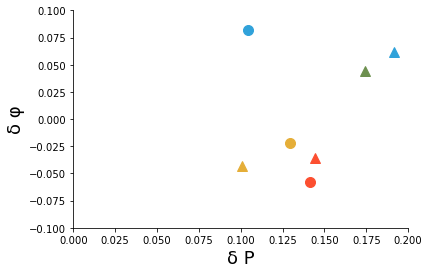

In [9]:
fig, ax = plt.subplots()


for x in delta_xfrac:
    model = x.split('-')[0]    
    if 'aqua' in x:
        m = 'o'
    else:
        m = '^'
    if 'off' in x:
        continue  # skip off -- just doing +4K
    xval = delta_mean[x]
    yval = delta_xfrac[x]
    ax.plot(xval, yval, marker=m, color=model_colors[model], markersize=10)

ax.set_xlabel("\u03b4 P", loc='center', fontsize=18)
ax.set_ylabel("\u03b4 \u03c6", loc='center', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([0, 0.2])
ax.set_ylim([-0.1, 0.1])
# ax.set_aspect('equal')
print(ax.get_aspect())

Text(0.5, 1.0, 'Extreme Precipitation Fraction')

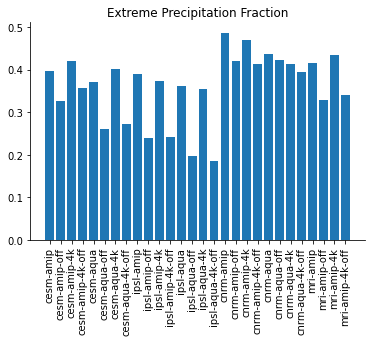

In [12]:
xfrac = {}
for s in R:
    xfrac[s] = R[s].xsum/R[s].tsum

fig, ax = plt.subplots()
ax.bar(np.arange(1, len(xfrac)+1), xfrac.values())
ax.set_xticks(np.arange(1, len(xfrac)+1))
ax.set_xticklabels(list(xfrac.keys()), rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Extreme Precipitation Fraction")

Text(0.5, 1.0, '95th Percentile')

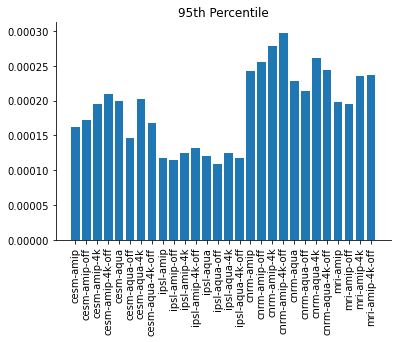

In [13]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(R)+1), [R[r].p95 for r in R])
ax.set_xticks(np.arange(1, len(R)+1))
ax.set_xticklabels(list(R.keys()), rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("95th Percentile")

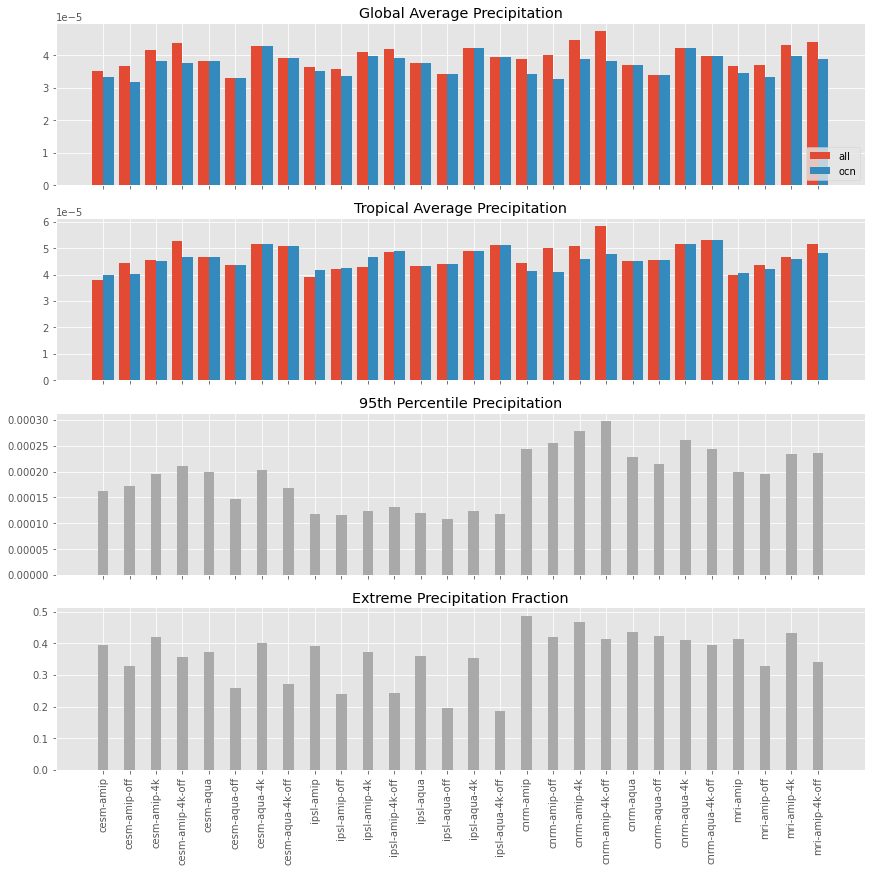

In [61]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(12,12), nrows=4, sharex=True, constrained_layout=True)
    ax[0].bar(np.arange(1, len(R)+1), [R[r].goavg for r in R], width=0.4, alpha=1, label='all')
    ax[0].bar(0.4+np.arange(1, len(R)+1), [R[r].gavg for r in R], width=0.4, alpha=1, label='ocn')
    ax[0].set_xticks(0.2+np.arange(1, len(R)+1))
    ax[0].set_xticklabels(list(R.keys()), rotation=90)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].set_title("Global Average Precipitation")
    ax[0].legend(loc='lower right')
    
    ax[1].bar(np.arange(1, len(R)+1), [R[r].toavg for r in R], width=0.4, alpha=1)
    ax[1].bar(0.4+np.arange(1, len(R)+1), [R[r].tavg for r in R], width=0.4, alpha=1)
    ax[1].set_xticks(0.2+np.arange(1, len(R)+1))
    ax[1].set_xticklabels(list(R.keys()), rotation=90)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].set_title("Tropical Average Precipitation")
    
    ax[2].bar(0.2+np.arange(1, len(R)+1), [R[r].p95 for r in R], width=0.4, alpha=1, color='darkgray')
    ax[2].set_xticks(0.2+np.arange(1, len(R)+1))
    ax[2].set_xticklabels(list(R.keys()), rotation=90)
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].set_title("95th Percentile Precipitation")
    
    ax[3].bar(0.2+np.arange(1, len(R)+1), [R[r].xsum/R[r].tsum for r in R], width=0.4, alpha=1, color='darkgray')
    ax[3].set_xticks(0.2+np.arange(1, len(R)+1))
    ax[3].set_xticklabels(list(R.keys()), rotation=90)
    ax[3].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)
    ax[3].set_title("Extreme Precipitation Fraction")

    fig.savefig('/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/summary_bars_base_and_p4K_and_LWoff.pdf', bbox_inches='tight')

In [43]:
(np.linspace(1, 2*(len(R))+1, len(R)+1)).shape

(29,)

In [37]:
np.linspace?

Signature:
np.linspace(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
)
Docstring:
Return evenly spaced numbers over a specified interval.

Returns `num` evenly spaced samples, calculated over the
interval [`start`, `stop`].

The endpoint of the interval can optionally be excluded.

.. versionchanged:: 1.16.0
    Non-scalar `start` and `stop` are now supported.

Parameters
----------
start : array_like
    The starting value of the sequence.
stop : array_like
    The end value of the sequence, unless `endpoint` is set to False.
    In that case, the sequence consists of all but the last of ``num + 1``
    evenly spaced samples, so that `stop` is excluded.  Note that the step
    size changes when `endpoint` is False.
num : int, optional
    Number of samples to generate. Default is 50. Must be non-negative.
endpoint : bool, optional
    If True, `stop` is the last sample. Otherwise, it is not included.
    Default is True.
retstep : 